# HR (Hertzsprung-Russell) Diagram Solution

The [Hertzsprung-Russell diagram](https://en.wikipedia.org/wiki/Hertzsprung–Russell_diagram) is a fundamental diagram in astronomy that displays important relationships between the stellar color (or temperature) and absolute brightness (or luminosity).

In this exercise, we will use existing stellar catalogs to produce the H-R diagram.

In [1]:
# As a hint, we include the code block for Python modules that you will likely need to import:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# For downloading files
from astropy.utils.data import download_file
from astropy.io import fits

import pyvo as vo
from pyvo import registry

## There are a number of relatively unimportant warnings that
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")

## Step 1: Find appropriate catalogs

We want to find a star catalog that has the available data to produce the H-R diagram, i.e., the absolute magnitudes (or both apparent magnitudes AND distances, so we can calculate the absolute magnitudes) in two optical bands (e.g., B and V). This would give us color. Or we need B- OR V- band magnitude and the stellar temperature.

To simplify this problem, we want to find a catalog of an open cluster of stars, where all the stars were born around the same time and are located in one cluster. This simplifies the issue of getting accurate distances to the stars. One famous cluster is the Pleiades in the constellation of Taurus. So first we start by searching for an existing catalog with data on Pleiades that will provide the necessary information about the stars: magnitudes in two bands (e.g., B and V), which can be used to measure color, or temperature of the star plus one magnitude.

### DATA DISCOVERY STEPS

Here is useful link for [how the pyvo registry search works](https://pyvo.readthedocs.io/en/latest/registry/index.html).

In [2]:
tap_services = registry.search(servicetype = 'tap', keywords=['star pleiades'], includeaux=True)
print(len(tap_services))
tap_services.get_summary()

137


index,short_name,title,description,interfaces
int64,str16,str55,str4800,str7
0,I/163,US Naval Observatory Pleiades Catalog,"This catalog is a special subset of the Eichhorn et al. (1970) Pleiades catalog (see <I/90>) updated to B1950.0 positions and with proper motions added. It was prepared for the purpose of predicting occultations of Pleiades stars by the Moon, but is useful for general applications because it contains many faint stars not present in the current series of large astrometric catalogs.",tap#aux
1,I/258,Pleiades positions and proper motions,"Based on a preliminary reference catalogue, combined with the catalogues PPM, ACRS and those in Eichhorn et al (1970, Cat. <I/90>), Jones (1973A&AS....9..313J) and Hertzsprung (1947AnLei..19a...1H), 33 exposures on 11 plates taken with the Zo-Se 40cm refractor (f=6895mm) in 86 years are reduced with the central overlapping technique, and high-precision positions and proper motions of 441 stars in the Pleiades astrometric standard region are obtained. The standard errors of star positions are less than +/-0.05arcsec, and the standard errors of proper motions for 90% stars in our reduction are less than +/-0.001arcsec/yr.",tap#aux
2,I/90,Positions of 502 Stars in Pleiades Region,"The catalog contains the positions (equinox B1900.0 and epoch B1955.0) of 502 stars in a region of about 1.5 degrees square in the Pleiades cluster, centered on Eta Tau. These coordinates have been derived from measurements of stellar images obtained with 65 exposures of various durations on 14 photographic plates with two telescopes at McCormick Observatory and Van Vleck Observatory. The plates were reduced by the plate overlap method, which resulted in a high degree of systematic accuracy in the final positions. Data in the machine version include Hertzsprung number, color index, photovisual magnitude, right ascension and declination and their standard errors, proper motion, and differences between the present position and previous works. Data for exposures, plates, and images measured, present in the published catalog, are not included in the machine version.",tap#aux
3,II/131,Tonantzintla Pleiades Flare Stars,"The original catalog lists the flare stars discovered by different astronomical observatories over an area slightly larger than 20 square degrees in the Pleiades regions centered on Alcyone. Not all the flare stars are members of this cluster, membership indicators are provided in the catalog. The catalog, combining Tables 1 and 2 of the publication, gives the data for 1531 flares of 519 flare stars.",tap#aux
4,II/44,K-Line photometry of stars in Population I clusters,"Photoelectric photometry of the K-line of calcium has been performed for the A stars of five open clusters (Hyades, Pleiades, IC 2391, IC 2602, and NGC 6475) and one association (Orion). All observations were carried out simultaneously with the field stars measurements in Paper II (II/43), with the 16-inch (40cm) and 36-inch (91cm) telescopes of the Cerro Tololo Inter-American Observatory, between May 1969 and January 1970.",tap#aux
5,J/A+A/299/696,Pleiades field Membership probabilities,"A catalogue of proper motions and photographic B,V magnitudes for stars up to B=19 mag within a region centered near Alcyone is presented. The catalogue is based on MAMA measurements of 8 plates taken with the Tautenburg Schmidt telescope. The survey includes ca. 14500 stars and covers a total field of about 9 square degrees. Membership probabilities, proper motions and B,V magnitudes are listed for 442 stars up to B=19 mag in the Pleiades field.",tap#aux
6,J/A+A/320/74,Radial velocities of Pleiades members,"The analysis of CORAVEL radial velocities of 93 stars selected on the basis of their proper motion and Geneva CCD photometric observations for 57 stars have permitted to identify 25 new members in the outer part of the Pleiades. Several spectroscopic binaries have been discovered, but their membership is not clear. Two orbits with short 

Note: The includeaux=True includes auxiliary services.

Because we specified the service type, this returns only the TAP services for each of the avalible resorces matching our search criteria.  So, the 'interfaces' column will only show TAP service as an avalible service, even if other services are avalible from the same resource. We know we need the service to be a TAP service since we know that we want to eventually access the search using additional column information (i.e., beyond RA and Dec, which is all that Simple Cone Search returns).

#### Next, we need to find which of these has the columns of interest, i.e. magnitudes in two bands to create the color-magnitude diagram

We can re-run the registry search, but further restrict the results by column UCD.  We want tables that have magnitude columns; the most basic UCD to describe a magnitude column is phot.mag

In [3]:
tap_services = registry.search(servicetype='tap', keywords=['star pleiades'],
                               ucd = ['phot.mag%'], includeaux=True)
print(len(tap_services))

91


Note: the '%' serves as a wild card when searching by UCD

The IOVA standard enables resources to be as sepecific as they would like when defining the UCD of columns.  For example, 'phot.mag' and 'phot.mag;em.opt.V' can both be used to describe a column containing the V magnitudes of objects.  If a resource uses the latter to describe a column, a search using 'phot.mag' will not return that resource.  A wild card would need to be used or the exact column UCD. The UCD search requires an exact match for a resource to be returned, so using the wild card will make it easier to discover a wider variety of resources.

So using this we can reduce the matched tables to ones that are a bit more catered to our experiment. Note, that there can be redundancy in some resources since these are available via multiple services and/or publishers. Therefore a bit more cleaning can be done to provide only the unique matches.

In [4]:
tap_services.to_table()['ivoid']

ivo://cds.vizier/i/163
ivo://cds.vizier/i/90
ivo://cds.vizier/ii/131
ivo://cds.vizier/ii/44
ivo://cds.vizier/j/a+a/299/696
ivo://cds.vizier/j/a+a/320/74
ivo://cds.vizier/j/a+a/323/139
ivo://cds.vizier/j/a+a/329/101
ivo://cds.vizier/j/a+a/332/575
ivo://cds.vizier/j/a+a/333/897
ivo://cds.vizier/j/a+a/341/751


In [5]:
def getunique( result ):
    short_name = []
    unique_ind = []
    for i in range(len(result)):
        short = result[i].short_name
        if short not in short_name:
            short_name.append(short)
            unique_ind.append(i)
        else:
            print(i)

    return(unique_ind)

In [6]:
uniq_ind=getunique(tap_services)
print(len(uniq_ind))

91


In [7]:
tap_services.to_table()[uniq_ind]['ivoid']

ivo://cds.vizier/i/163
ivo://cds.vizier/i/90
ivo://cds.vizier/ii/131
ivo://cds.vizier/ii/44
ivo://cds.vizier/j/a+a/299/696
ivo://cds.vizier/j/a+a/320/74
ivo://cds.vizier/j/a+a/323/139
ivo://cds.vizier/j/a+a/329/101
ivo://cds.vizier/j/a+a/332/575
ivo://cds.vizier/j/a+a/333/897
ivo://cds.vizier/j/a+a/341/751


This shows that in this case, all of our TAP results are unique.

We can read more information about the results we found.  For each resource element (i.e. row in the table above), there are useful attributes, which are [described here]( https://pyvo.readthedocs.io/en/latest/api/pyvo.registry.regtap.RegistryResource.html#pyvo.registry.regtap.RegistryResource)

In [8]:
# To read the descriptions of the resulting matches:

for i in uniq_ind:
    print("  ***  \n")
    print(tap_services[i].creators)
    print(tap_services[i].res_description)


  ***  

['Van Flandern T.C.']
This catalog is a special subset of the Eichhorn et al. (1970) Pleiades catalog (see <I/90>) updated to B1950.0 positions and with proper motions added. It was prepared for the purpose of predicting occultations of Pleiades stars by the Moon, but is useful for general applications because it contains many faint stars not present in the current series of large astrometric catalogs.
  ***  

['Eichhorn H.', ' Googe W.D.', ' Lukac C.F.', ' Murphy J.K.']
The catalog contains the positions (equinox B1900.0 and epoch B1955.0) of 502 stars in a region of about 1.5 degrees square in the Pleiades cluster, centered on Eta Tau. These coordinates have been derived from measurements of stellar images obtained with 65 exposures of various durations on 14 photographic plates with two telescopes at McCormick Observatory and Van Vleck Observatory. The plates were reduced by the plate overlap method, which resulted in a high degree of systematic accuracy in the final posit

<i> RESULT: Based on these, the second one (by Eichhorn et al) looks like a good start. </i>

### At this point, you can proceed to Step 2

-- OR --

### Try a different data discovery method

### Alternative Method: Use ADS to search for appropriate paper and access data via NED

There are multiple paths for the data discovery. So it may also be that you know the paper that has the data you are interested in and want to access via the bibcode or authors, etc.

In this case, let's assume that we have the information that the Eichhorn+1970 paper has the data that we need to create the H-R diagram: <https://ui.adsabs.harvard.edu/abs/1970MmRAS..73..125E/abstract>

We can either search by bibcode (1970MmRAS..73..125E) or "Eichhorn" to get the access_urls that will allow us to work with the data.

Before this step, if may help to see the names of the fields available to use. Notice the following fields:

"source_value" contains the bibcode information that we want; "creator_seq" lists the authors;

and

"access_url" provides the url from where the data can be accessed.

In [9]:
## You already have this from above:
# tap_services = registry.search(servicetype='tap', keywords=['star pleiades'],
#                                ucd = ['phot.mag%'], includeaux=True)
print(tap_services.fieldnames)

('ivoid', 'res_type', 'short_name', 'res_title', 'content_level', 'res_description', 'reference_url', 'creator_seq', 'created', 'updated', 'rights', 'content_type', 'source_format', 'source_value', 'region_of_regard', 'waveband', 'access_urls', 'standard_ids', 'intf_types', 'intf_roles', 'alt_identifier')


First, Try using bibcode:

In [10]:
bibcode = '1970MmRAS..73..125E' # Eichhorn
idx=-1
for s in tap_services:
    idx+=1
    if bibcode in s['source_value']:
        myidx=idx
        print(f"{s.short_name}, {s.source_value}, {s.access_url}")
        break
#  Note that using the to_table() lets you search the result
#   easily using all columns.  But in the end, you want to get
#   back not an astropy table row, which you cannot use, but the
#   original RegistryResult that has the callable TAP service.
myTAP=tap_services[myidx]

I/90, 1970MmRAS..73..125E, http://tapvizier.cds.unistra.fr/TAPVizieR/tap


Note that the URL is a generic TAP url for Vizier.  All of its tables can be accessed by that same TAP services.  It'll be in the ADQL query itself that you specify the table name.  We'll see this below.

Next, try using Author name:

In [11]:
author = 'Eichhorn'

for record in tap_services:
    names=record.creators
    if 'Eichhorn' in names[0]:
        print("For %s: " %record.short_name)
        print("     Access URL: %s" %record['access_urls'][0])
        print("     Reference URL: %s" %record.reference_url)


For I/90: 
     Access URL: http://tapvizier.cds.unistra.fr/TAPVizieR/tap
     Reference URL: https://cdsarc.cds.unistra.fr/viz-bin/cat/I/90


In the code above, the record is a Registry Resource. You can access the attribute, "creators", from the resource, which is relevant for our example here since this is a direct way to get the author names. The other attributes, "access_url" and "reference_url", provides two types of URLs. The former can be used to access the service resource (as described above) and the latter points to a human-readable document describing this resource.

If you click on the Reference URL links, you can find the abstract, Readme file, Vizier table, and much more information associated with this catalog.

Additional information about PyVO Registry Resource and its attributes is available <a href="https://pyvo.readthedocs.io/en/latest/api/pyvo.registry.regtap.RegistryResource.html#pyvo.registry.regtap.RegistryResource "> from this page</a>.

<P> *** <P>

These examples provide a few ways to access the information of interest.

Below are a few other ways to see what the tap_service table contains.

1. To view the column information: tap_services.to_table().columns() shows the metadata contained in the tap service. We will reference some of this columns below as we try to find the appropriate table.

2. tap_services[index].describe(): The table with the tap_services output has, in our case, 83 tables listed and each includes metadata containing some human readable description. You can get the description for one case or for all the records by iterating through the resource. In the former case, we show the description for the Eichhorn data, whose index is uniq_ind[1]. The latter case also follows.

In [12]:
print( tap_services.to_table().columns )

<TableColumns names=('ivoid','res_type','short_name','res_title','content_level','res_description','reference_url','creator_seq','created','updated','rights','content_type','source_format','source_value','region_of_regard','waveband','access_urls','standard_ids','intf_types','intf_roles','alt_identifier')>


In [13]:
tap_services[uniq_ind[1]].describe()   # For Eichhorm+1970 example.

Positions of 502 Stars in Pleiades Region
Short Name: I/90
IVOA Identifier: ivo://cds.vizier/i/90
Access modes: tap#aux
Base URL: http://tapvizier.cds.unistra.fr/TAPVizieR/tap

The catalog contains the positions (equinox B1900.0 and epoch B1955.0) of 502
stars in a region of about 1.5 degrees square in the Pleiades cluster,
centered on Eta Tau. These coordinates have been derived from measurements of
stellar images obtained with 65 exposures of various durations on 14
photographic plates with two telescopes at McCormick Observatory and Van Vleck
Observatory. The plates were reduced by the plate overlap method, which
resulted in a high degree of systematic accuracy in the final positions. Data
in the machine version include Hertzsprung number, color index, photovisual
magnitude, right ascension and declination and their standard errors, proper
motion, and differences between the present position and previous works. Data
for exposures, plates, and images measured, present in the publishe

In [14]:
# To iterate over all the tables:
for tapsvc in tap_services:
    print("---------------------------------------------  \n")
    tapsvc.describe()

---------------------------------------------  

US Naval Observatory Pleiades Catalog
Short Name: I/163
IVOA Identifier: ivo://cds.vizier/i/163
Access modes: tap#aux
Base URL: http://tapvizier.cds.unistra.fr/TAPVizieR/tap

This catalog is a special subset of the Eichhorn et al. (1970) Pleiades
catalog (see <I/90>) updated to B1950.0 positions and with proper motions
added. It was prepared for the purpose of predicting occultations of Pleiades
stars by the Moon, but is useful for general applications because it contains
many faint stars not present in the current series of large astrometric
catalogs.

Waveband Coverage: optical
---------------------------------------------  

Positions of 502 Stars in Pleiades Region
Short Name: I/90
IVOA Identifier: ivo://cds.vizier/i/90
Access modes: tap#aux
Base URL: http://tapvizier.cds.unistra.fr/TAPVizieR/tap

The catalog contains the positions (equinox B1900.0 and epoch B1955.0) of 502
stars in a region of about 1.5 degrees square in the Pleiade

## Step 2: Acquire the relevant data and make a plot

In order to query the table, we need the table name, note this is NOT the same as the short name we found above:

In [15]:
tables = tap_services[uniq_ind[1]].service.tables

short_name = "I/90"
# find table name:
for name in tables.keys():
    if short_name in name:
        print(name)

VI/90/archives
VI/90/maindata
VI/90/quality
VI/90/notes
VI/90/observer
I/90/catalog
VIII/90/first12


We can write code to eliminate the other cases (e.g., VI or VIII...) but we wanted to keep this cell to illustrate that the table name (which is required for the query) will likely include the short_name appended to "/catalog" (or "/table").

But the other roman numeral catalogs are obviously different catalogs. Therefore try the below for a better match:

In [16]:
# find (more restricted) table name:
for name in tables.keys():
    if name.startswith(short_name):
        print(name)
        tablename=name

I/90/catalog


In [17]:
query = 'SELECT * FROM "%s"' %tablename
print(query)
results = tap_services[short_name].search(query)
results.to_table()

SELECT * FROM "I/90/catalog"


recno,Hertzsprung,CI,Ptm,RAB1900,e_RAs,DEB1900,e_DEs,rmsRA,rmsDE,rpmRA,rpmDE,DrpmRA,DrpmDE,DRA,DDE
,,mag,mag,deg,ms,deg,mas,,,mas / yr,mas / yr,mas / yr,mas / yr,arcsec,arcsec
int32,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64
126,884,1.51,12.73,55.03883749999999,4.3,22.995927777777773,50,0.49,0.39,--,--,--,--,--,--
131,923,0.66,10.08,55.06343333333333,1.4,23.027888888888885,16,0.58,0.7,--,--,--,--,--,--
146,1021,1.26,10.42,55.12255833333332,1.5,23.011119444444443,18,0.41,0.64,--,--,--,--,--,--
90,712,1.05,13.21,54.91535416666666,5.8,23.042222222222218,65,0.5,0.42,--,--,--,--,--,--
107,802,0.0,14.44,54.97971666666666,5.2,23.035311111111106,61,0.4,0.33,--,--,--,--,--,--
124,882,1.15,12.55,55.038283333333325,3.4,23.09319722222222,43,0.42,0.48,--,--,--,--,--,--
111,815,0.82,12.01,54.986058333333325,2.7,23.118880555555553,33,0.61,0.49,--,--,--,--,--,--
66,580,0.3,12.65,54.82563333333333,9.7,22.981605555555554,96,0.25,0.22,--,--,--,--,--,--


We can access the column data as array using the .getcolumn(colname) attribute, where the colname is given in the table above. In particular the "CI" is the color index and "Ptm" is the photovisual magnitude. See [here](https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=I/90) for details about the columns.

In [18]:
color = results.getcolumn('CI')
mag = results.getcolumn('Ptm')

### Plotting

Note: The magnitudes here are apparent and therefore in plotting, the color-magnitude diagram is typically brightness increasing upwards (higher y-axis) so we will flip the y-axis here.

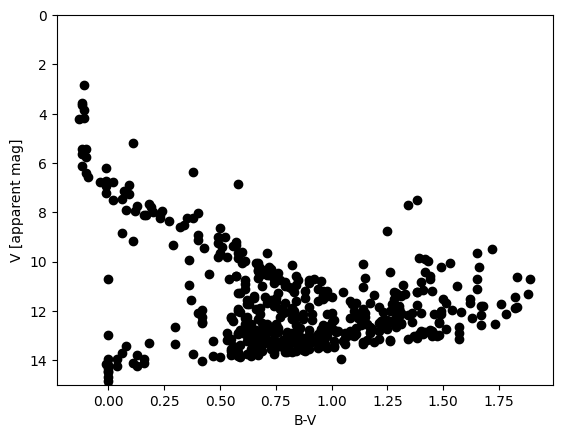

In [19]:
plt.ylim(15, 0)
plt.ylabel("V [apparent mag]")
plt.xlabel("B-V")

plt.plot(color, mag, 'o', color='black')

## Step 3. Compare with other color-magnitude diagrams for Pleiades

There is nice discussion here: <http://www.southastrodel.com/Page03009a.htm>  about the color-magnitude diagram. Their Fig 4 looks slightly cleaner because part of this investigation was to select the 270 stars that are vetted members and restricted to stellar types more massive than K0.

The dataset is from Raboud+1998 (1998A&A...329..101R)

Therefore in this next step, we will use the bibcode to select this data and overplot with the previous data to compare.

In [20]:
bibcode = '1998A&A...329..101R' # Raboud
all_bibcodes = tap_services.getcolumn('source_value')
all_shortnames = tap_services.getcolumn('short_name')

match = np.where(all_bibcodes == bibcode)

# Show relevant short_name (for Raboud paper):
short_name = all_shortnames[match][0]
print(short_name)
print("----------")
ind = int(match[0])

tap_services[ind].describe()

J/A+A/329/101
----------
Masses of Pleiades members
Short Name: J/A+A/329/101
IVOA Identifier: ivo://cds.vizier/j/a+a/329/101
Access modes: tap#aux
Base URL: http://tapvizier.cds.unistra.fr/TAPVizieR/tap

On the basis of the best available member list and duplicity information, we
have studied the radial distribution of 270 stars and multiple systems earlier
than K0 in the Pleiades. Five new long period spectroscopic binaries have been
identified from the CORAVEL observations. We have found a clear mass
segregation between binaries and single stars, which is explained by the
greater average mass of the multiple systems. The mass function of the single
stars and primaries appears to be significantly different. While the central
part of the cluster is spherical, the outer part is clearly elliptical, with
an ellipticity of 0.17. The various parameters describing the Pleiades are
(for a distance of 125pc): core radius r_c_=0.6 deg (1.4pc), tidal radius
r_t_=7.4 (16pc), half mass radius r_m

/tmp/ipykernel_2202/2733767379.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(match[0])


In [21]:
# Doing steps above to view table from Raboud+1998

# This 'tables' will return the same service tables as the 'tables' defined
# ealier in Step 2, since both the Eichhorn+1970 and Raboud+1998 come from the
# same service. Therfore, we did not need to redefine 'tables', but we kept it
# for completion, as different tables don't always use the same service.
tables = tap_services[ind].service.tables

# find table name:
for name in tables.keys():
    if short_name in name:
        tablename = name

# Another way to find the table name:
# Raboud_table = tap_services[short_name].get_tables()
# tablename = [name for name in Raboud_table.keys()][0]

query = 'SELECT * FROM "%s"' %tablename
print(query)
results = tap_services[ind].search(query)
results.to_table()

SELECT * FROM "J/A+A/329/101/table3"


recno,HII,Vmag,B-V,xpos,ypos,Dist,Mult,Rem,Mass,MassA,MassB,MassC,MassD
,,mag,mag,arcmin,arcmin,arcmin,,,Msun,Msun,Msun,Msun,Msun
int32,int32,float64,float64,float64,float64,float64,int16,object,float64,float64,float64,float64,float64
1,25,9.47,0.48,-55.52,22.81,60.02,1,,1.2,--,--,--,--
2,34,11.99,0.93,-53.62,33.49,63.22,1,,0.81,--,--,--,--
3,97,12.62,1.08,-48.27,52.86,71.58,2,IRB,1.21,0.73,0.48,--,--
4,102,10.51,0.71,-49.4,-53.25,72.64,2,IRB,1.45,0.97,0.45,--,--
5,120,10.79,0.7,-47.4,-26.36,54.23,2,SB1,1.53,0.98,0.55,--,--
6,129,11.47,0.88,-46.91,-21.06,51.42,1,,0.84,--,--,--,--
7,152,10.73,0.69,-46.07,-34.67,57.66,1,,0.99,--,--,--,--
8,153,7.51,0.15,-44.39,57.94,72.99,1,,1.74,--,--,--,--


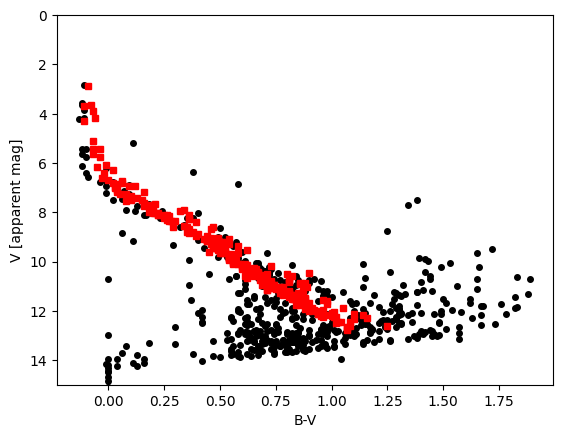

In [22]:
R98_color = results.getcolumn('B-V')
R98_mag = results.getcolumn('Vmag')

plt.ylim(15, 0)
plt.ylabel("V [apparent mag]")
plt.xlabel("B-V")
plt.plot(color, mag, 'o', markersize=4.0, color='black') ## This is Eichhorn data
plt.plot(R98_color, R98_mag, 's', markersize=5.0, color='red') ## This is new data from Raboud+98

## BONUS: Step 4: The CMD as a distance indicator

Since the y-axis above is apparent magnitude, we can use the obvious features (e.g., main sequence curve) to translate the apparent magnitudes to absolute magnitudes (by comparing to published H-R diagrams given in absolute magnitudes) and measure the distance to Pleiades!

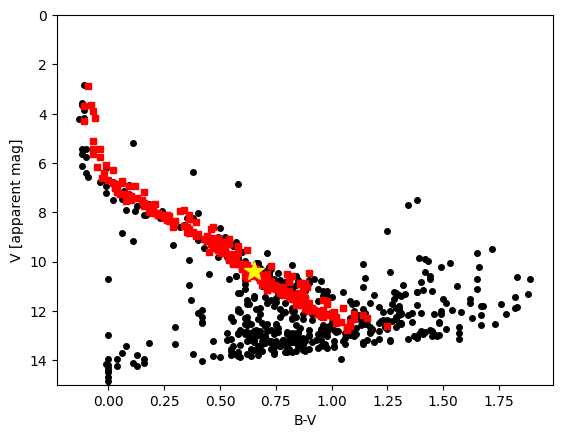

In [23]:
R98_color = results.getcolumn('B-V')
R98_mag = results.getcolumn('Vmag')

sun_color = 0.65  # from http://www.astro.ucla.edu/~wright/magcolor.htm
sun_mag = 10.4   # Played with this value until it looked centered in relation at the B-V color above (yellow star!)

plt.ylim(15, 0)
plt.ylabel("V [apparent mag]")
plt.xlabel("B-V")
plt.plot(color, mag, 'o', markersize=4.0, color='black') ## This is Eichhorn data
plt.plot(R98_color, R98_mag, 's', markersize=5.0, color='red') ## This is new data from Raboud+98
plt.plot(sun_color, sun_mag, '*', markersize=15.0, color='yellow') ## This is our estimated center point

In [24]:
# Another measure... use the Sun:
Vabs = 4.8   ## Sun @ B-V = 0.65 (taken from Wikipedia)
Vapp = 10.4  ## Based on rough reading of plot above at B-V = 0.65

dm= Vapp - Vabs   # distance module = 5log d / 10pc.
dist = 10. ** (dm / 5. + 1.)
print("%10.1f pc " %dist)

     131.8 pc 


True distance to Pleaides is 136.2 pc ( <https://en.wikipedia.org/wiki/Pleiades> ). Not bad!